In [1]:
# 출처: 서대호(2019), 잡아라! 텍스트마이닝 with 파이썬
# LDA 파라미터튜닝을 도전해보자 (https://coredottoday.github.io/2018/09/17/모델-파라미터-튜닝/)
# Blei, D. M. Ng. A. Y., & Jordan, M. I. (2003). Latent dirichlet allocation. Journal of machine Learning research, 3(Jan), 993-1022
# Online Learning for Latent Dirichlet Allocation (https://proceedings.neurips.cc/paper/2010/file/71f6278d140af599e06ad9bf1ba03cb0-Paper.pdf)
# Topic modeling visualization – How to present the results of LDA models? (https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/)

In [114]:
import pandas as pd
import numpy as np

from gensim import corpora, models
from gensim.models.ldamodel import LdaModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel
import gensim

import warnings
import time

from konlpy.tag import Okt
okt = Okt()


In [24]:
data = pd.read_csv('신문기사모음.csv', encoding = 'cp949')
text = data.body

In [170]:
wordTypeOkt=okt.tagset
print(wordTypeOkt)

{'Adjective': '형용사', 'Adverb': '부사', 'Alpha': '알파벳', 'Conjunction': '접속사', 'Determiner': '관형사', 'Eomi': '어미', 'Exclamation': '감탄사', 'Foreign': '외국어, 한자 및 기타기호', 'Hashtag': '트위터 해쉬태그', 'Josa': '조사', 'KoreanParticle': '(ex: ㅋㅋ)', 'Noun': '명사', 'Number': '숫자', 'PreEomi': '선어말어미', 'Punctuation': '구두점', 'ScreenName': '트위터 아이디', 'Suffix': '접미사', 'Unknown': '미등록어', 'Verb': '동사'}


In [173]:
for i, document in enumerate(text):

    # okt = Okt()
    clean_words = []
    for word in okt.pos(document, stem=True): #어간 추출
        if word[1] not in ['Josa', 'Eomi', 'Punctuation', 'Foreign', 'Suffix' ,'URL', 'Conjunction', 'Verb', 'Number']: #조사, 어미, 구두점, 외국어/기호, url, 동사, 숫자 제외 
            clean_words.append(word[0])
    # print(clean_words) 
    document = ' '.join(clean_words)
    # print(document) 
    text[i] = document

print(text[0], text[1])

NHN 빅풋 한게임 웹 보드 게임 노하우 접목 스포츠 예측 게임 한게임 승부 예측 출시 한게임 승부 예 측은 게임 내 재화 활용 스포츠 경기 결과 예측 게임 실제 전세계 스포츠 경기 데이터 바탕 결과 힐 경우 배당률 게임 멀다 제공 다 특히 NHN 빅풋 한게임 웹 보드 게임 개발 및 서비스 노하우 바탕 차별 스포츠 예측 게임 먼저 축구 야구 농구 등 대중 인기 스포츠 외 아이스하키 테니스 탁구 등 종 이상 방대하다 종목 제공 선택 국내 프로 스포츠 아니다 잉글랜드 프리미어리그 EPL 메이저리그 MLB 미국 프로농구 NBA 같다 글로벌 인기 리그 모두 포함 스포츠 예측 항목 승무 패 핸디캡 언 더 오버 포함 여종 달 다 이용자 경기 당 결과 예측 다양하다 항목 선택 전략 게임 수 있다 또한 이용자 성향 수 있다 콘텐츠 마련 크로스 경기 내 여러 항목 조합 수 있다 높다 수준 예측 가능하다 스페셜 전반전 혹은 쿼터 등 결과 제공 빠르다 호흡 게임 수 있다 라이브 실제 경기 시작 후 상황 실시간 예측 수 있다 특별하다 방식 이 승부 예측 게임 처음 접 이용자 쉬 수 있다 직관 깔끔하다 UI 를 적용 북마크 활용 주요 경기 추천 Hot League 관심 경기 저장 My Favorite 과 같다 기능 제공 이용자 편의 높이 경 기별 전력 분석 토론 등 통해 경기 결과 예측 도움 한게임 승부 예 측은 별도 설치 과정 없이 웹페이지 바로 게임 수 있다 NHN 은 올해 연결 기준 매출 영업 이익 기록 지난해 같다 기간 각각 것 실적 결제 커머스 사업 코로나 여파 비대 시장 확장 사업 성장하다 매출 부문 별로 결제 광고 매출 전 년 대비 오른 기록 페이 코 페이 코 쿠폰 등 NHN 페이 코 매출 성장 세 NHN 한국 사이버 결제 온라인 PG 전자 지급 결제 대행 서비스 해외 가맹 점 결제 증가 매출 상승 특히 페이 코 거래 규모 작년 증가 그중 오프라인 결제 규모 전 년 동기 대비 배 이상 성장하다 비중 확대 비대 오프라인 주문 서비스 페이 코 가맹 점 말 개 주문 건수 전 

In [174]:
# tokenize 
okt=Okt()
tokens = []
stopwords = ['하다', '되다', '있다', '들다', '기자']

'''각 기사별로 토큰들 나눠서 리스트로 만들기'''
# [ [1번 기사의 토큰들], [2번 기사의 토큰들], [3번 기사의 토큰들]... [n번 기사의 토큰들] ]
for line in text:
    tokens.append(okt.morphs(line))

    
'''
tokens -> 각 기사별 토큰 list를 모아놓은 list   (list를 모은 list)
'''


# tokens_processed = {}
text_processed = []

# 기사 하나하나 마다 [토큰 리스트]에 담긴 한글자짜리 토큰 제거
temp_index = 0
for lst in tokens:
    ''' 여기서 각 기사 한줄 한줄씩 처리함 '''
    
    
    # 딕셔너리에 담을 때 표시하기 위한 인덱스....
    
    
    # 딕셔너리에 담을 토큰들 모아놓는 리스트....
    temp_words_list = []
    
    
    for wd in lst:
        ''' 여기서 기사별 [토큰list] 속 단어(토큰)들을 처리함 '''
        
        if len(wd) < 2:
            # 한글자 짜리면 무시하고 지나침
            continue
            
        if wd in stopwords:
            # 불용어에 해당하는 단어면 무시하고 지나침
            continue
        
        # 둘다 해당하지 않으면 임시 리스트에 담기
        temp_words_list.append(wd)
    
    
    # 필터링한 데이터 저장
    # tokens_processed[temp_index] = temp_words_list
    # temp_index +=1
    text_processed.append(temp_words_list)

    ''' 
      0 : [ 기사1 토큰리스트 ]
      1 : [ 기사2 토큰리스트 ]
      2 : [ 기사3 토큰리스트 ]
    ...
    122 : [ 기사122 토큰리스트 ]
    
    (temp_index)    :  (temp_wors_list) 
    이런 형식으로 dictionary(tokens_processed)에 저장
    
    '''
    

# 만들어진 딕셔너리
# tokens_processed
text_processed[:2]

[['NHN',
  '빅풋',
  '한게임',
  '보드',
  '게임',
  '노하우',
  '접목',
  '스포츠',
  '예측',
  '게임',
  '한게임',
  '승부',
  '예측',
  '출시',
  '한게임',
  '승부',
  '측은',
  '게임',
  '재화',
  '활용',
  '스포츠',
  '경기',
  '결과',
  '예측',
  '게임',
  '실제',
  '전세계',
  '스포츠',
  '경기',
  '데이터',
  '바탕',
  '결과',
  '경우',
  '배당률',
  '게임',
  '멀다',
  '제공',
  '특히',
  'NHN',
  '빅풋',
  '한게임',
  '보드',
  '게임',
  '개발',
  '서비스',
  '노하우',
  '바탕',
  '차별',
  '스포츠',
  '예측',
  '게임',
  '먼저',
  '축구',
  '야구',
  '농구',
  '대중',
  '인기',
  '스포츠',
  '아이스하키',
  '테니스',
  '탁구',
  '이상',
  '방대하다',
  '종목',
  '제공',
  '선택',
  '국내',
  '프로',
  '스포츠',
  '아니다',
  '잉글랜드',
  '프리미어리그',
  'EPL',
  '메이저리그',
  'MLB',
  '미국',
  '프로농구',
  'NBA',
  '같다',
  '글로벌',
  '인기',
  '리그',
  '모두',
  '포함',
  '스포츠',
  '예측',
  '항목',
  '승무',
  '핸디캡',
  '오버',
  '포함',
  '여종',
  '이용자',
  '경기',
  '결과',
  '예측',
  '다양하다',
  '항목',
  '선택',
  '전략',
  '게임',
  '또한',
  '이용자',
  '성향',
  '콘텐츠',
  '마련',
  '크로스',
  '경기',
  '여러',
  '항목',
  '조합',
  '높다',
  '수준',
  '예측',
  '가능하다',
  '스페셜',
  '전반전',
  '혹은',
  '쿼

In [175]:
# text_processed: list -> dict 변환
tokens_dictionary = corpora.Dictionary(text_processed)
print(tokens_dictionary)

Dictionary(3569 unique tokens: ['EPL', 'Favorite', 'Hot', 'League', 'MLB']...)


In [176]:
# 문서-단어 매트릭스 형성
tokens_corpus = [tokens_dictionary.doc2bow(text) for text in text_processed]
print(tokens_corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 2), (11, 1), (12, 11), (13, 5), (14, 8), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 2), (42, 1), (43, 1), (44, 1), (45, 1), (46, 2), (47, 1), (48, 1), (49, 2), (50, 1), (51, 1), (52, 1), (53, 2), (54, 1), (55, 1), (56, 1), (57, 1), (58, 7), (59, 1), (60, 4), (61, 1), (62, 1), (63, 2), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 10), (71, 1), (72, 1), (73, 1), (74, 4), (75, 2), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 4), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 2), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 2), (107, 1), (108, 1), (109, 1), (110, 5

In [177]:
# LDA modeling, temp num topics = 3
ldamodel = gensim.models.ldamodel.LdaModel(tokens_corpus, num_topics=3, id2word = tokens_dictionary)

In [178]:
# 5 words per topic
ldamodel.print_topics(num_words=5)

[(0, '0.045*"게임" + 0.016*"매출" + 0.013*"NHN" + 0.009*"대비" + 0.008*"증가"'),
 (1, '0.019*"게임" + 0.013*"매출" + 0.006*"대비" + 0.006*"NHN" + 0.006*"출시"'),
 (2, '0.042*"게임" + 0.021*"매출" + 0.011*"대비" + 0.009*"NHN" + 0.009*"규제"')]

In [179]:
# 0번째 문서의 topic 분포
ldamodel.get_document_topics(tokens_corpus)[0]

[(0, 0.9956328)]

In [180]:
# # Init
# num_topics = 10 # temp num topics
# passes = 20 # epoch
# iterations = 400 
# eval_every = None # ldamodel1
# # alpha, eta = auto # Dirichlet Gamma param


# %time model = LdaModel(corpus = corpus, id2word = tokens_dictionary, alpha ="auto", eta="auto", iterations = iterations, num_topics = num_topics, passes = passes, eval_every = eval_every)

In [181]:
tokens_perplexities = []
tokens_coherences = []
passes=[]
warnings.filterwarnings('ignore')

for i in range(10):
    
    ntopics, nwords = 200, 100
    if i==0:
        p=1
    else:
        p=i*5
    tic = time.time()
    lda4 = LdaModel(tokens_corpus, id2word=tokens_dictionary, num_topics=ntopics, iterations=400, passes=p)
    print('epoch',p,time.time() - tic)
    passes.append(p)
    # lda = models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=ntopics, iterations=200000)

    cm = CoherenceModel(model=lda4, corpus=tokens_corpus, coherence='u_mass')
    coherence = cm.get_coherence()
    print("Coherence",coherence)
    tokens_coherences.append(coherence)
    print('Perplexity: ', lda4.log_perplexity(tokens_corpus),'\n')
    tokens_perplexities.append(lda4.log_perplexity(tokens_corpus))

epoch 1 5.510269403457642
Coherence -0.5954805016682546
Perplexity:  -8.830986704364653 

epoch 5 9.058815717697144
Coherence -0.5611831672213863
Perplexity:  -7.812618058028724 

epoch 10 12.684091091156006
Coherence -0.5378177353587621
Perplexity:  -7.400632006771058 

epoch 15 16.852946281433105
Coherence -0.6089412326619623
Perplexity:  -7.280959666730282 

epoch 20 19.5068519115448
Coherence -0.6559948689914051
Perplexity:  -7.309744697348082 

epoch 25 23.36852765083313
Coherence -0.5140837052226543
Perplexity:  -7.242541965927247 

epoch 30 26.3316068649292
Coherence -0.5967268063736771
Perplexity:  -7.214544961935992 

epoch 35 30.541353702545166
Coherence -0.590174402143961
Perplexity:  -7.197199088786483 

epoch 40 35.04132032394409
Coherence -0.5801937557410628
Perplexity:  -7.211724606392773 

epoch 45 40.869324684143066
Coherence -0.6393249839699143
Perplexity:  -7.224705434531573 



In [182]:
tokens_coherences

[-0.5954805016682546,
 -0.5611831672213863,
 -0.5378177353587621,
 -0.6089412326619623,
 -0.6559948689914051,
 -0.5140837052226543,
 -0.5967268063736771,
 -0.590174402143961,
 -0.5801937557410628,
 -0.6393249839699143]

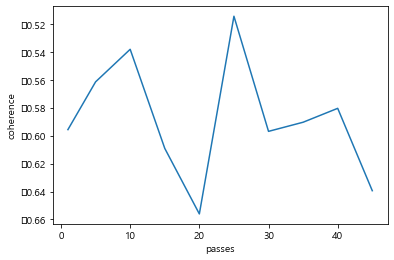

In [183]:
import matplotlib.pyplot as plt

plt.plot(passes, tokens_coherences)
plt.xlabel("passes")
plt.ylabel("coherence")
plt.show()

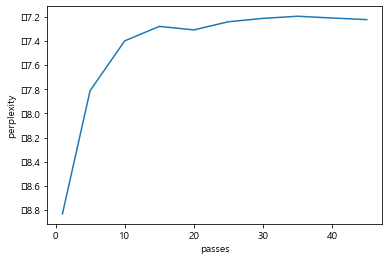

In [184]:
plt.plot(passes, tokens_perplexities)
plt.xlabel("passes")
plt.ylabel("perplexity")
plt.show()

In [186]:
perplexities_values=[]
coherences_values=[]

for i in range(1, 21):

    lda_model = LdaMulticore(corpus=tokens_corpus, id2word = tokens_dictionary, num_topics = i, passes =25)
#    print('number of topics',p,time.time() - tic)
    coherence_model = CoherenceModel(model = lda_model, corpus = tokens_corpus, coherence = 'u_mass')
    tok_coherence = coherence_model.get_coherence()
    print("coherence:", tok_coherence)
    coherences_values.append(tok_coherence)
    print("perplexity:", lda_model.log_perplexity(tokens_corpus), "\n")
    perplexities_values.append(lda_model.log_perplexity(tokens_corpus))

coherence: -0.6608188565836857
perplexity: -7.013108501152637 

coherence: -0.7626599677101316
perplexity: -6.868917650228254 

coherence: -0.687717545553275
perplexity: -6.792905075982467 

coherence: -1.6981169110675596
perplexity: -6.8037860673013055 

coherence: -1.2730688450433418
perplexity: -6.782950575668212 

coherence: -1.304249267949053
perplexity: -6.758883021485716 

coherence: -1.550225181074352
perplexity: -6.724219934302014 

coherence: -2.274995762438587
perplexity: -6.79910752528139 

coherence: -1.7779511502005114
perplexity: -6.7380129610625605 

coherence: -1.4438796258367854
perplexity: -6.714796243196225 

coherence: -1.6052201020155996
perplexity: -6.784589683062242 

coherence: -1.2117370791635407
perplexity: -6.7496185858219295 

coherence: -1.6608846249537668
perplexity: -6.782453752970858 

coherence: -1.226183967526588
perplexity: -6.738545236625643 

coherence: -1.485739500789427
perplexity: -6.720675107033367 

coherence: -1.727451197979307
perplexity: -6

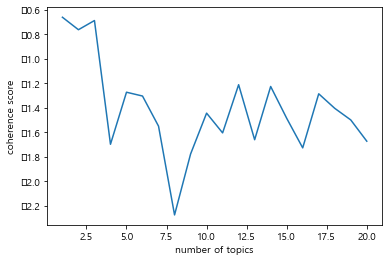

In [187]:
x = np.arange(1,21)
plt.plot(x, coherences_values)
plt.xlabel("number of topics")
plt.ylabel("coherence score")
plt.show()

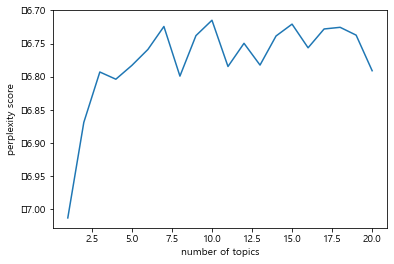

In [188]:
x = np.arange(1,21)
plt.plot(x, perplexities_values)
plt.xlabel("number of topics")
plt.ylabel("perplexity score")
plt.show()

In [189]:
lda_model = LdaMulticore(corpus = tokens_corpus, num_topics = 12.5, id2word = tokens_dictionary, passes = 25, iterations=400)
topics = lda_model.print_topics()
for topic in topics:
    print(topic)

(0, '0.036*"게임" + 0.014*"매출" + 0.013*"네오위즈" + 0.011*"개발" + 0.009*"출시" + 0.009*"투자" + 0.009*"보드" + 0.008*"성장" + 0.008*"모바일" + 0.006*"하반기"')
(1, '0.014*"물류" + 0.014*"투자" + 0.010*"코로나" + 0.010*"기업" + 0.009*"산업" + 0.009*"경제" + 0.008*"통신" + 0.008*"온라인" + 0.008*"HMR" + 0.008*"리츠"')
(2, '0.035*"NHN" + 0.033*"매출" + 0.032*"게임" + 0.025*"대비" + 0.020*"부문" + 0.019*"증가" + 0.018*"사업" + 0.017*"결제" + 0.015*"동기" + 0.010*"분기"')
(3, '0.063*"게임" + 0.037*"스포츠" + 0.023*"베팅" + 0.013*"시장" + 0.010*"서비스" + 0.010*"포커" + 0.009*"예측" + 0.008*"출시" + 0.008*"국내" + 0.007*"NHN"')
(4, '0.000*"애초" + 0.000*"암호" + 0.000*"연수기" + 0.000*"어쩌다" + 0.000*"애플리케이션" + 0.000*"예매" + 0.000*"애드" + 0.000*"아이즈" + 0.000*"아퀴스" + 0.000*"예시"')
(5, '0.062*"게임" + 0.045*"이용자" + 0.038*"보드게임" + 0.037*"규제" + 0.030*"한도" + 0.029*"보호" + 0.022*"불법" + 0.021*"방안" + 0.020*"환전" + 0.019*"손실"')
(6, '0.060*"스포츠" + 0.049*"예측" + 0.031*"게임" + 0.027*"서비스" + 0.026*"승부" + 0.022*"경기" + 0.021*"스튜디오" + 0.021*"대표" + 0.021*"나부" + 0.018*"리그"')
(7, '0.047*"게임" + 0.016*"규제" 

In [190]:
topic_words = {};

for i in range(7): 
    words = lda_model.show_topic(i, topn = 13)
    topic_words['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words]
    
topic_table = pd.DataFrame(topic_words)

In [196]:
topic_table.columns = [
    '게임회사 실적 및 성장 전략',
    '코로나19 산업 영향',
    'NHN엔터 신사업 및 실적', 
    '승부 예측 게임 매출 성장', 
    '게임 업계 산업 다각화',
    # 'NHN엔터 다양한 사업 분야', 
    # '게임회사 실적 및 성장 전략', 
    '웹보드 게임 규제 완화', 
    '스포츠 베팅 게임 성장'
    # '증권가 게임 산업 분석', 
    # '게임사 신사업 성장 동력', 
    # '코로나19 게임 산업 영향', 
    ]
topic_table

,게임회사 실적 및 성장 전략,코로나19 산업 영향,NHN엔터 신사업 및 실적,승부 예측 게임 매출 성장,게임 업계 산업 다각화,웹보드 게임 규제 완화,스포츠 베팅 게임 성장
0,게임,물류,NHN,게임,예매,게임,스포츠
1,매출,투자,매출,스포츠,예시,이용자,예측
2,네오위즈,코로나,게임,베팅,아이즈,보드게임,게임
3,개발,기업,대비,시장,아퀴스,규제,서비스
4,출시,산업,부문,서비스,안정화,한도,승부
5,투자,경제,증가,포커,암호,보호,경기
6,보드,통신,사업,예측,애드,불법,스튜디오
7,성장,온라인,결제,출시,애초,방안,대표
8,모바일,리츠,동기,국내,애플리케이션,환전,나부
9,하반기,HMR,분기,NHN,어쩌다,손실,리그


## Visualization

In [197]:
# Dominant topic and its percentage contribution in each document

def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=tokens_corpus, texts=text_processed)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.4121,"게임, 매출, 네오위즈, 개발, 출시, 투자, 보드, 성장, 모바일, 하반기","[NHN, 빅풋, 한게임, 보드, 게임, 노하우, 접목, 스포츠, 예측, 게임, 한게임, 승부, 예측, 출시, 한게임, 승부, 측은, 게임, 재화, 활용, 스포츠, 경기, ..."
1,1,2.0,0.9569,"NHN, 매출, 게임, 대비, 부문, 증가, 사업, 결제, 동기, 분기","[NHN, 올해, 연결, 기준, 매출, 영업, 이익, 기록, 지난해, 같다, 기간, 각각, 실적, 결제, 커머스, 사업, 코로나, 여파, 비대, 시장, 확장, 사업, 성장하..."
2,2,2.0,0.6890,"NHN, 매출, 게임, 대비, 부문, 증가, 사업, 결제, 동기, 분기","[엠게임, 실제, 스포츠, 경기, 데이터, 기반, 스포츠, 승부, 예측, 게임, 윈플레, 출시, 플레이, 승무, 패핸디캡, 오버, 같다, 주제, 경기, 결과, 예측, 게임머..."
3,3,2.0,0.4243,"NHN, 매출, 게임, 대비, 부문, 증가, 사업, 결제, 동기, 분기","[엠게임, 지난, 실제, 스포츠, 경기, 데이터, 기반, 스포츠, 승부, 예측, 게임, 이하, 승부, 예측, 게임, 플레이, 사진, 출시, 앞서, NHN, 빅풋, 잼팟, 승..."
4,4,9.0,0.7211,"게임, 카지노, 소셜, 넷마블, 산업, 규제, 사업, 국내, 시장, 업계","[커뮤니티, 기능, 차단, 무료, 재화, 랜덤, 매칭, 적용, 선제, 조치, 도입, 지속, 시스템, 개선, 통해, 건전하다, 보드게임, 환경, 만들기, 오위즈, 올바르다, ..."
5,5,6.0,0.9907,"스포츠, 예측, 게임, 서비스, 승부, 경기, 스튜디오, 대표, 나부, 리그","[넵튠, 자사, 서비스, 나부, 스튜디오, 개발, 스포츠, 승부, 예측, 서비스, 공식, 서비스, DDADA, 확정, 스포츠, 승부, 예측, 서비스, 한게임, 보드, 게임,..."
6,6,0.0,0.7433,"게임, 매출, 네오위즈, 개발, 출시, 투자, 보드, 성장, 모바일, 하반기","[엔씨, 넷마블, 엄청나다, 성적, 인하다, 주목, 네오위즈, 최근, 안정, 성장, 거듭, 회사, 하나, 국내, 상위, 퍼블리셔, 이름, 피파온라인, 계약, 종료, 야심, ..."
7,7,0.0,0.9979,"게임, 매출, 네오위즈, 개발, 출시, 투자, 보드, 성장, 모바일, 하반기","[열혈강호, 온라인, 엠게임, 최근, 상당하다, 힘드다, 시기, 회사, 하나, 야심, 열혈강호, 참담하다, 실패, 암흑, 시작, 모바일, 시대, 제대로, 대응, 계속, 하락..."
8,8,2.0,0.8745,"NHN, 매출, 게임, 대비, 부문, 증가, 사업, 결제, 동기, 분기","[지난, 네이버, 분사, NHN, 엔터테인먼트, 전망, 불투명, 자체, 한게임, 주력, 고스톱, 포커, 보드, 게임, 규제, 소리, 적자, 내부, 직원, 이직, 고민, 정도..."
9,9,0.0,0.9987,"게임, 매출, 네오위즈, 개발, 출시, 투자, 보드, 성장, 모바일, 하반기","[매출, 영업, 이익, 대비, 각각, 증가, 여기, 순이익, 대비, 상승, 지난, 네오위즈, 성적표, 매출, 영업, 이익, 이후, 연속, 성장하다, 만큼, 네오위즈, 실적,..."


In [198]:
# The most representative sentence for each topic

# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9987,"게임, 매출, 네오위즈, 개발, 출시, 투자, 보드, 성장, 모바일, 하반기","[매출, 영업, 이익, 대비, 각각, 증가, 여기, 순이익, 대비, 상승, 지난, 네오위즈, 성적표, 매출, 영업, 이익, 이후, 연속, 성장하다, 만큼, 네오위즈, 실적,..."
1,1.0,0.9985,"물류, 투자, 코로나, 기업, 산업, 경제, 통신, 온라인, HMR, 리츠","[그동안, 공유경제, 투자, 베다, 펀드, 고립, 경제, 지원, 새롭다, 베다, 투자, 고립, 경제, 시대, 도래, 포브스, 리다, 평가, 고립, 경제, 대부분, 해결, 업..."
2,2.0,0.9967,"NHN, 매출, 게임, 대비, 부문, 증가, 사업, 결제, 동기, 분기","[NHN, 지난해, 사상, 최대, 매출, 영업, 이익, 리다, 전자, 결제, 서비스, 페이, 실적, 게임, 커머스, 다른, 사업, 부문, 견조, 성장, 달성, NHN, 지난..."
3,3.0,0.9974,"게임, 스포츠, 베팅, 시장, 서비스, 포커, 예측, 출시, 국내, NHN","[최근, 셧다운제, 폐지, 움직임, 다시, 거세지다, 게임, 규제, 전반, 대한, 관심, 특히, 블록, 체인, 게임, 스포츠, 승부, 예측, 게임, 해외, 인기, 시장, 게..."
4,5.0,0.9966,"게임, 이용자, 보드게임, 규제, 한도, 보호, 불법, 방안, 환전, 손실","[네오위즈, 잼팟, 천백십일, 보드게임, 손실, 한도, 폐지, NHN, 엠게임, 회사, 손실, 한도, 폐지, 보드게임, 경쟁, 치열하다, 전망, 네오위즈, 게임, 시행, 개..."
5,6.0,0.9907,"스포츠, 예측, 게임, 서비스, 승부, 경기, 스튜디오, 대표, 나부, 리그","[넵튠, 자사, 서비스, 나부, 스튜디오, 개발, 스포츠, 승부, 예측, 서비스, 공식, 서비스, DDADA, 확정, 스포츠, 승부, 예측, 서비스, 한게임, 보드, 게임,..."
6,7.0,0.9977,"게임, 규제, 실적, 보드, 주가, 코로나, 완화, 증권, 예상, 시장","[실적, 시즌, 시작, 코로나, 영향, 상반기, 전반, 실적, 둔화, 국면, 불가피하다, 전망, 시가총액, 비중, 높다, 반도체, 업종, 코로나, 영향, 비교, 자유롭다, ..."
7,9.0,0.9992,"게임, 카지노, 소셜, 넷마블, 산업, 규제, 사업, 국내, 시장, 업계","[흥행, 산업, 어렵다, 누구, 배틀, 라운드, 개발, 마블, 시리즈, 같다, 영화, 방탄소년단, 같다, 아이돌, 아니다, 애초, 대중, 어떻다, 콘텐츠, 좋아하다, 혜안,..."
8,10.0,0.9976,"매출, 게임, 영업, 이익, 대비, 출시, 증가, 기록, 모바일, 동기","[컴투스, 서머, 이미지, 컴투스, 제공, 웹젠, 아크엔젤, 웹젠, 제공, 게임빌, 게임빌, 프로야구, 슈퍼스타즈, 이미지, 게임빌, 제공, 중견, 게임, 업계, 어닝, 서..."
9,11.0,0.9986,"인증, 코로나, 게임, 평가, 외국인, GUCC, 주가, 신청, 항목, 종목","[코로나, 직격탄, 코스피, 반등, 성공하다, 발길, 외국인, sell, 코리아, 현상, 기미, 보이지, 한국, 거래소, 외국인, 이후, 거래, 연속, 도세, 어가, 국내,..."


In [199]:
# doc_lens = [len(d) for d in df_dominant_topic.Text]

# # Plot
# plt.figure(figsize=(16,7), dpi=160)
# plt.hist(doc_lens, bins = 1000, color='navy')
# plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
# plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
# plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
# plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
# plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

# plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
# plt.tick_params(size=16)
# plt.xticks(np.linspace(0,1000,9))
# plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
# plt.show()

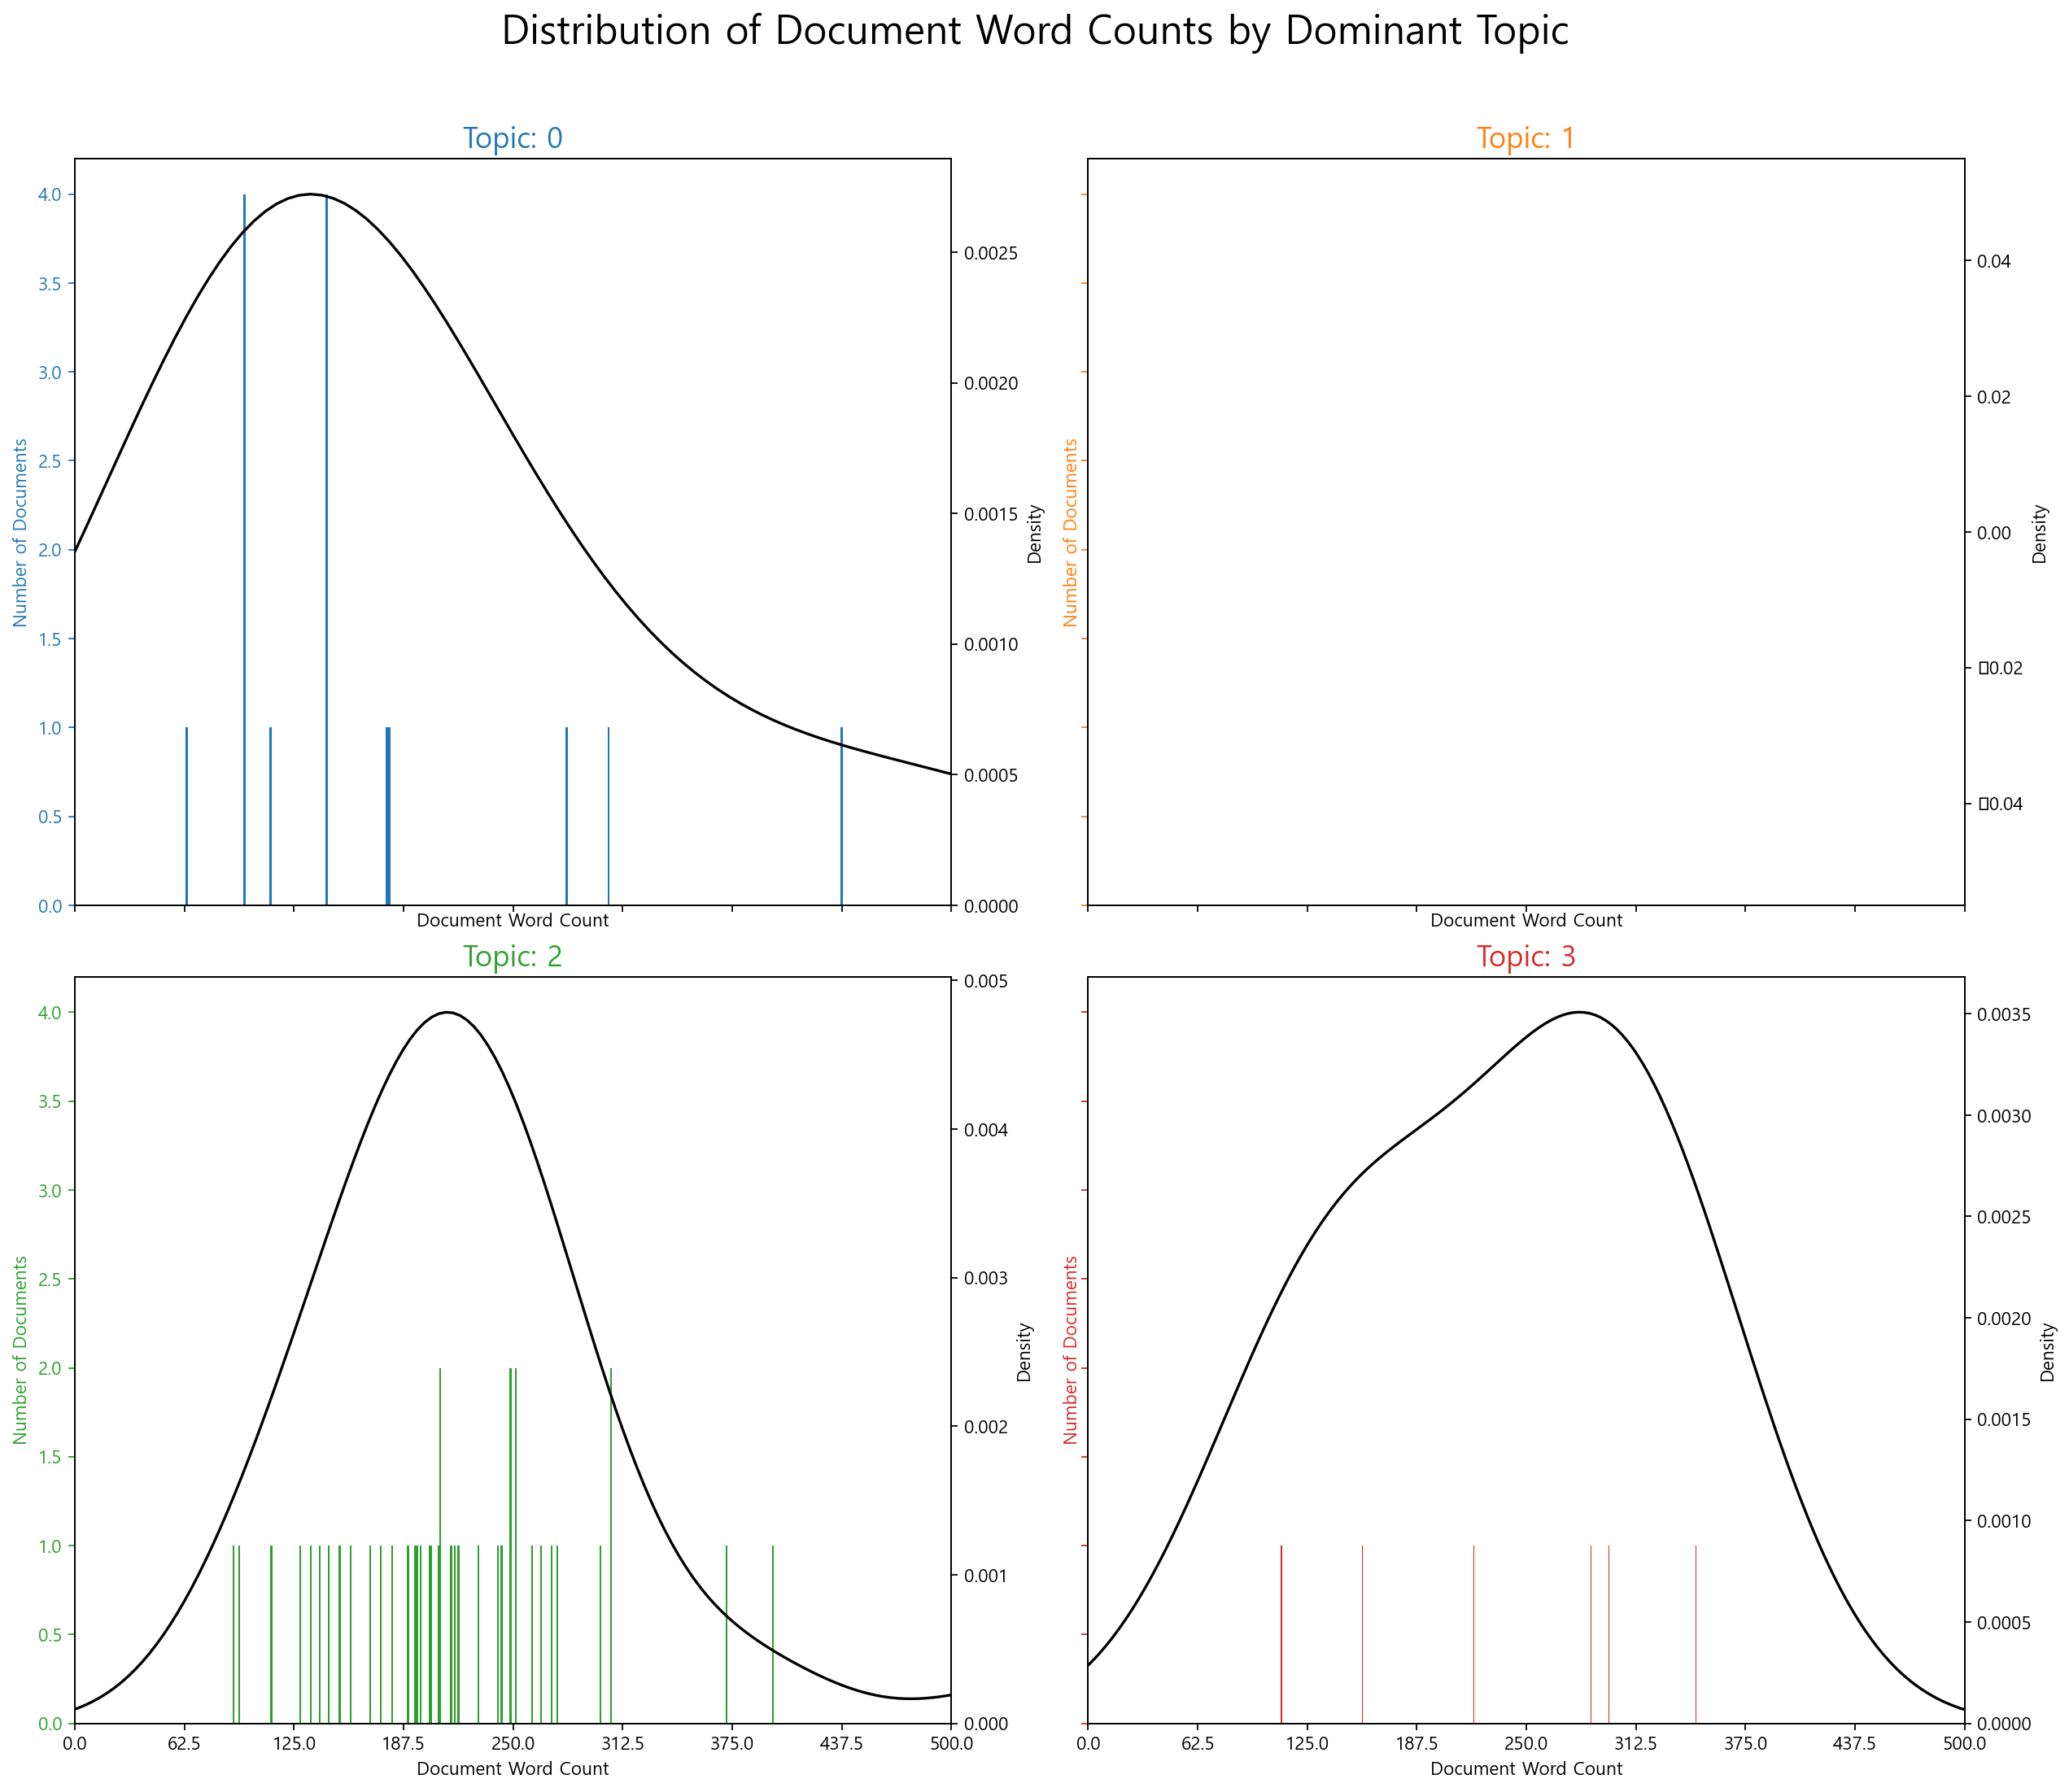

In [200]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 500, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 500), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,500,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

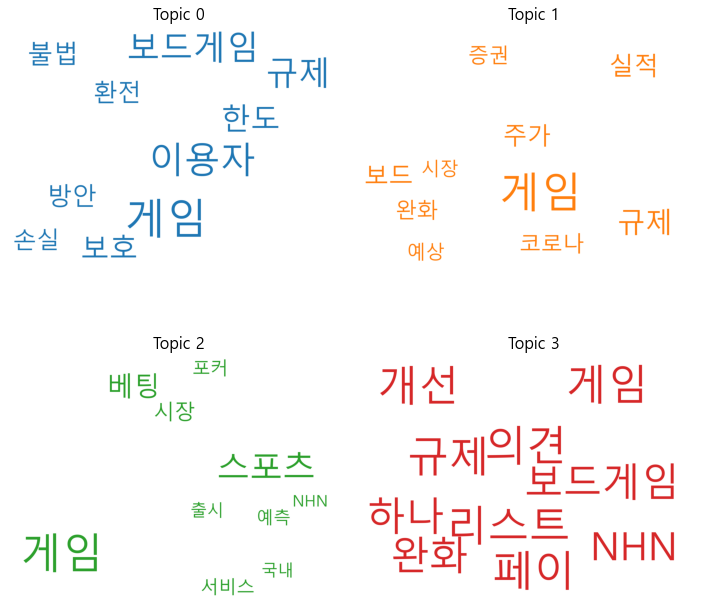

In [201]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(font_path="c:/Windows/Fonts/malgun.ttf",
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

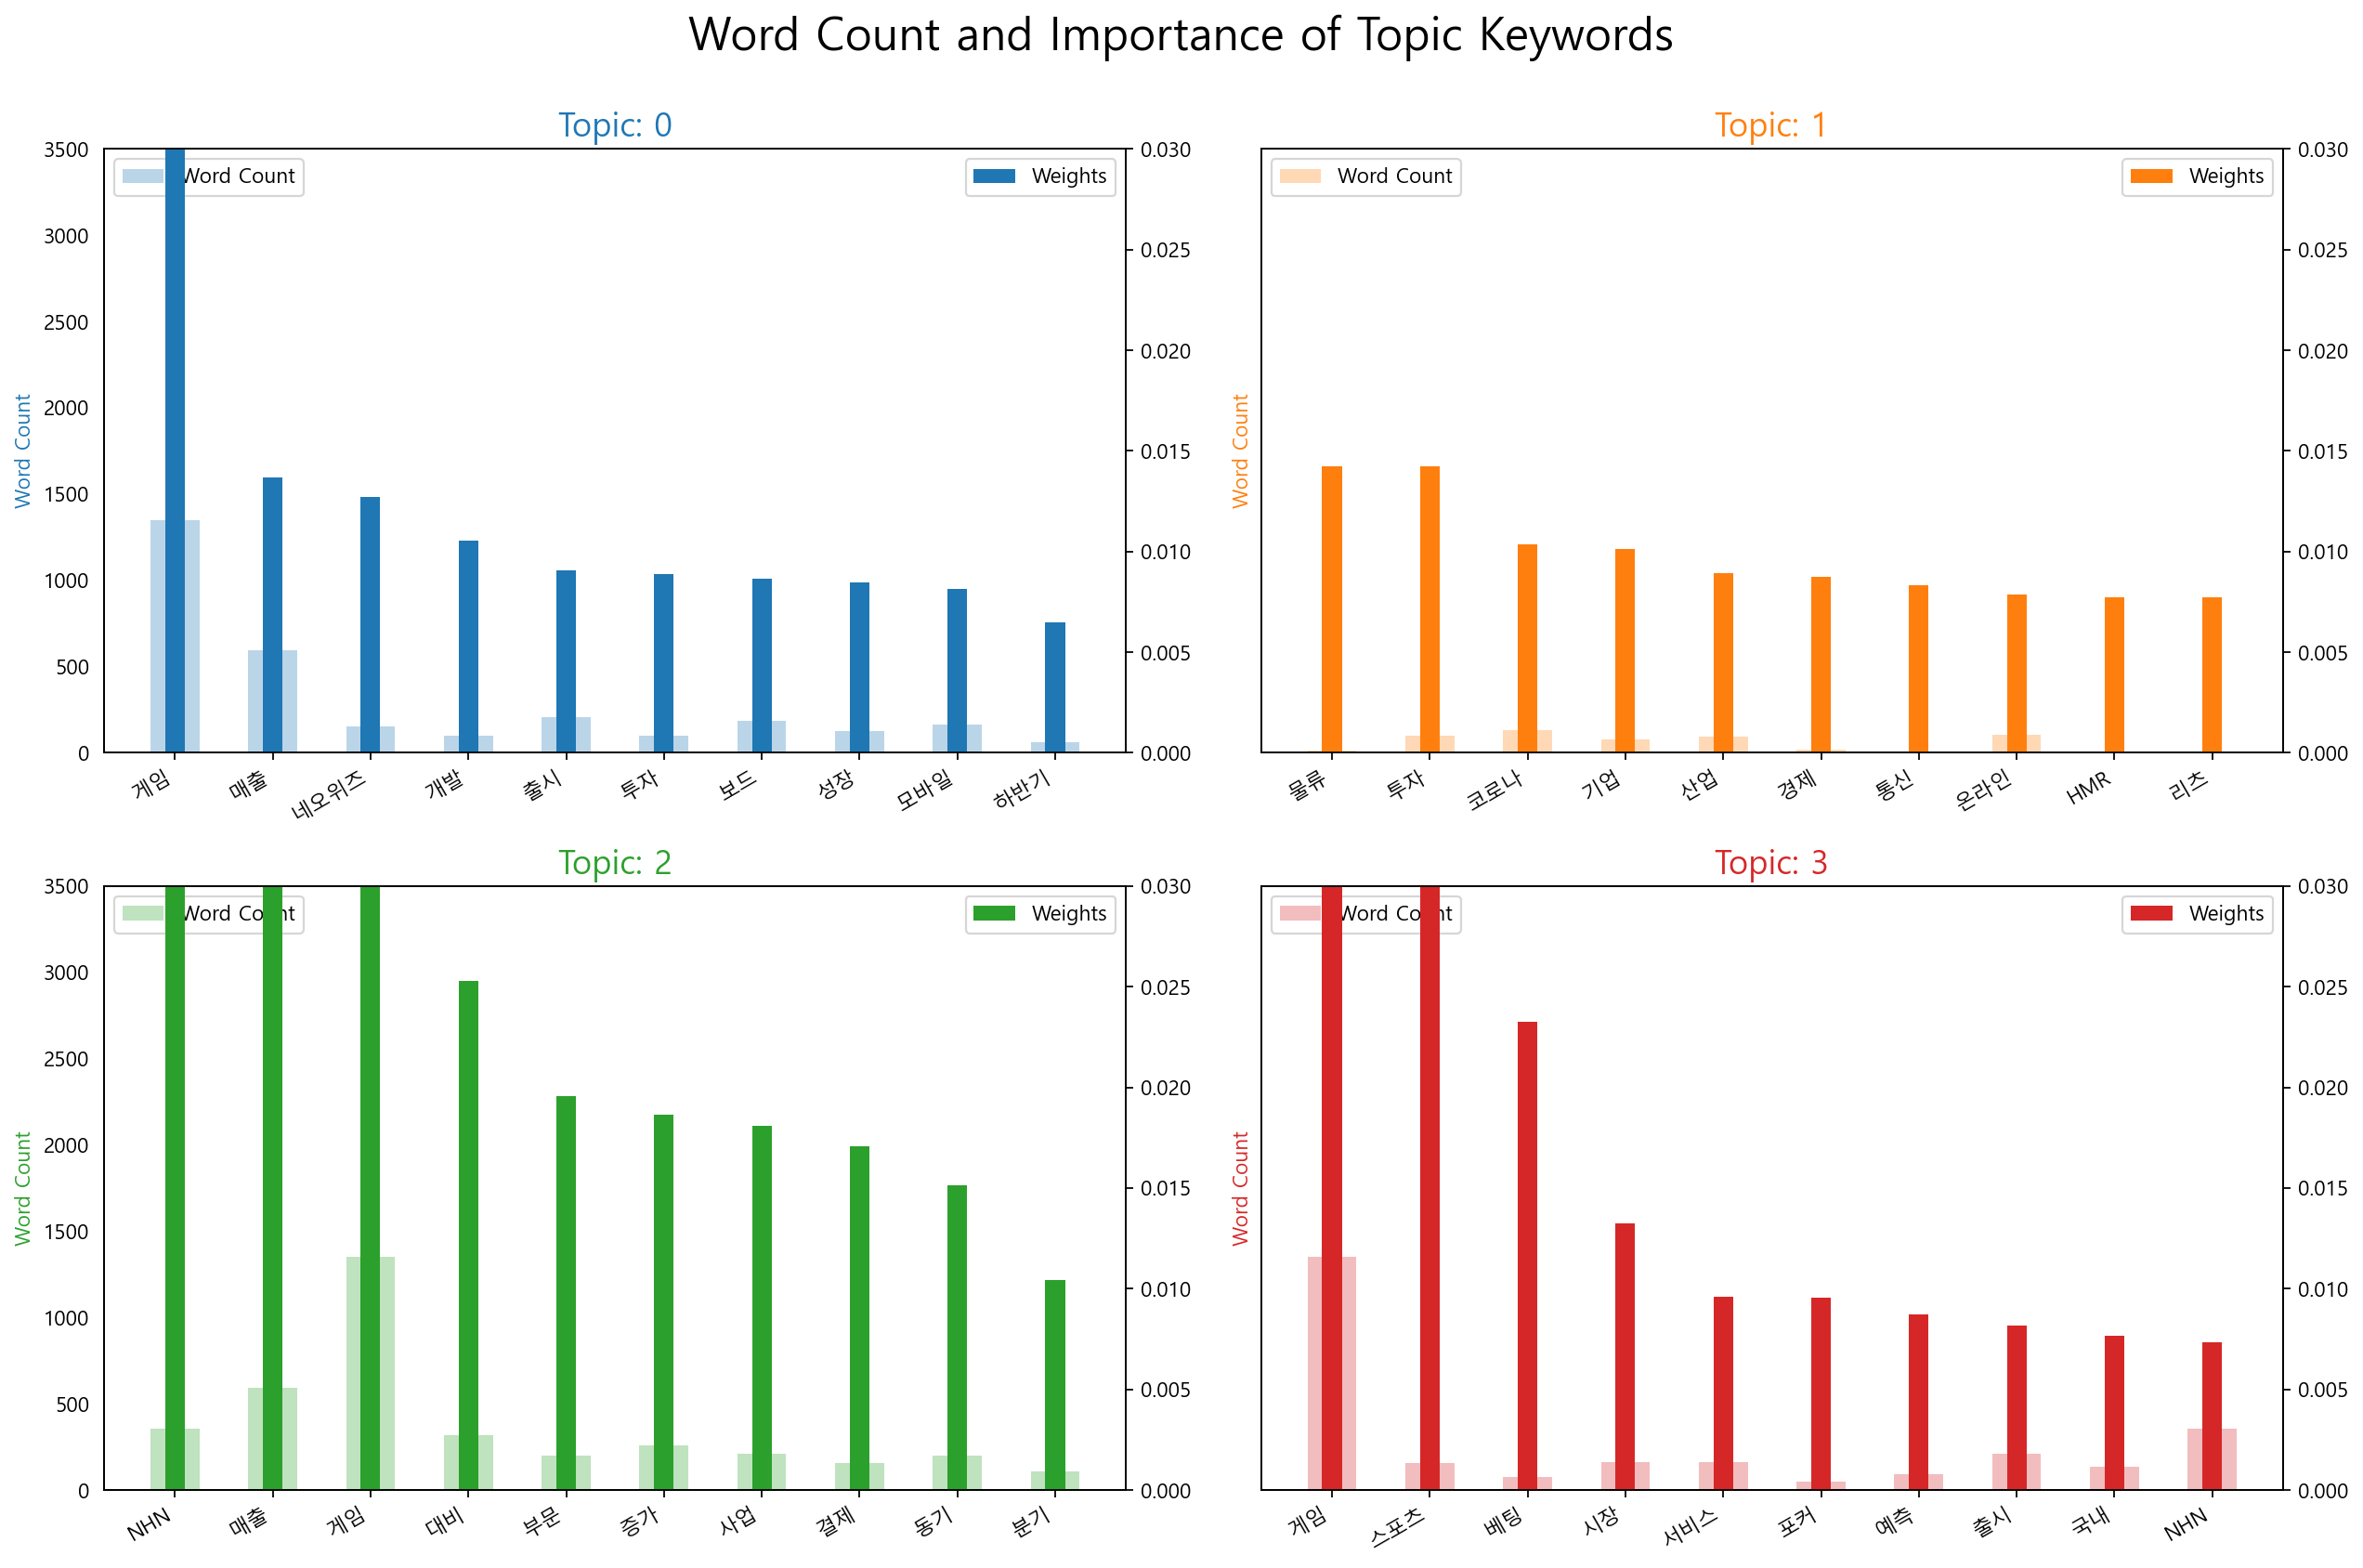

In [202]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in text_processed for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords

from matplotlib import font_manager, rc
# font_path = "C:/Windows/Fonts/NGULIM.TTF"
font_path="c:/Windows/Fonts/malgun.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [168]:
# # Sentence Coloring of N Sentences
# from matplotlib.patches import Rectangle

# def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
#     corp = corpus[start:end]
#     mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

#     fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
#     axes[0].axis('off')
#     for i, ax in enumerate(axes):
#         if i > 0:
#             corp_cur = corp[i-1] 
#             topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
#             word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
#             ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
#                     fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

#             # Draw Rectange
#             topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
#             ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
#                                    color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

#             word_pos = 0.06
#             for j, (word, topics) in enumerate(word_dominanttopic):
#                 if j < 14:
#                     ax.text(word_pos, 0.5, word,
#                             horizontalalignment='left',
#                             verticalalignment='center',
#                             fontsize=16, color=mycolors[topics],
#                             transform=ax.transAxes, fontweight=700)
#                     word_pos += .009 * len(word)  # to move the word for the next iter
#                     ax.axis('off')
#             ax.text(word_pos, 0.5, '. . .',
#                     horizontalalignment='left',
#                     verticalalignment='center',
#                     fontsize=16, color='black',
#                     transform=ax.transAxes)       

#     plt.subplots_adjust(wspace=0, hspace=0)
#     plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
#     plt.tight_layout()
#     plt.show()

# sentences_chart()    

In [169]:
# from matplotlib.ticker import FuncFormatter

# # Plot
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# # Topic Distribution by Dominant Topics
# ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic, width=.5, color='firebrick')
# ax1.set_xticks(range(df_dominant_topic.Dominant_Topic.unique().__len__()))
# tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
# ax1.xaxis.set_major_formatter(tick_formatter)
# ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
# ax1.set_ylabel('Number of Documents')
# ax1.set_ylim(0, 1000)

# # Topic Distribution by Topic Weights
# ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
# ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
# ax2.xaxis.set_major_formatter(tick_formatter)
# ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

# plt.show()